# Basic viscous flow
In this example, we will simulate various examples of a basic *unbounded* viscous flow---a flow without boundaries. Our initial condition will be a distribution of *vorticity*.

In [2]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1260


In [3]:
using Plots

### The basic steps
To carry out any simulation in `ViscousFlow`, we need to carry out a few basic steps:
* **Specify the problem**: Set the Reynolds number and free stream
* **Discretize**: Set up a solution domain, grid cell size, time step size
* **Construct the system structure**: Create the operators that will be used to perform the simulation
* **Initialize**: Set the initial flow field and initialize the integrator
* **Solve**: Solve the flow field
* **Examine**: Examine the results

We will go through all of these here. For the examples we will carry out in this notebook, the first three steps need only be carried out once.

### Problem specification
We will set the Reynolds number to be 200 and no free stream

In [60]:
Re = 200

200

### Discretize
We will set up a domain from x = -2 to x = 2, and y = -2 to y = 2. The Reynolds number helps us determine the grid spacing `Δx` and time step size `Δt`. To set these, we set a target *grid Reynolds number*, `gridRe`. We will set this to 4 here; if we ignore it, it defaults to 2. Note that this choice is a compromise:
* smaller grid Reynolds number means smaller grid spacing, and slower simulations
* larger grid Reynolds number means less accurate results

In [100]:
xlim = (-2.0,2.0)
ylim = (-2.0,2.0)

Δx, Δt = setstepsizes(Re,gridRe=4)

(0.02, 0.01)

### Construct the system structure
This part is easy - you just supply the parameters you have just set up. It returns a structure with all of the necessary mathematical operators:

In [101]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt)

Unbounded Navier-Stokes system on a grid of size 208 x 208 and 0 static immersed points
   Static freestream = (0.0, 0.0)


Now, we will solve a few different problems

## A basic example: the Lamb-Oseen vortex
This example starts with a single vortex with a Gaussian distribution of vorticity. To generate this, will use the `SpatialGaussian` function:

In [102]:
σ = 0.2
x0 = 0.0
y0 = 0.0
A = 1
gauss = SpatialGaussian(σ,x0,y0,A) # places a Gaussian with radius \sigma at (0,0) with strength 1.

SpatialGaussian(Gaussian(0.2, 0.0, 1, 2.8209479177387813), Gaussian(0.2, 0.0, 1, 2.8209479177387813), 1)

### Initialize
Now, we create an instance of this vorticity distribution on the grid. 

In [103]:
u0 = newstate(gauss,sys)

(Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), Float64[])

We use this initial condition to initialize the **integrator**. The integrator is the structure that holds all of our solution and operator information. With it, we can start the simulation, restart the simulation later, etc. We specify a range of time over which to advance the solution.

**Note**: This initial range is not very important, and we can always add on to it later. There is no need to restart the problem.

In [104]:
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), Float64[])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 1$:

In [105]:
step!(integrator,1.0)

We can see now that the solution has been advanced in time:

In [106]:
integrator

t: 1.0
u: (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), Float64[])

### Examine
Let's examine the results. It is important to show a few different ways that we can do this. The most straightforward way is to just look at the flow fields at the current state of the integrator. For example, to get the current velocity field, type `velocity(integrator)`. We can do the same for `vorticity`, `streamfunction` (the streamlines), `scalarpotential`, `convective_derivative`, and `pressure`.

We will look at some of these at the current state:

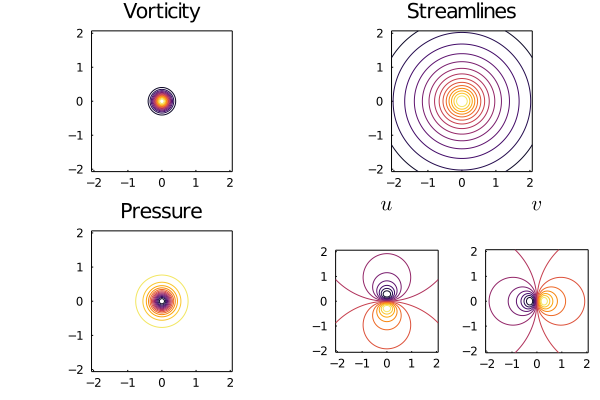

In [107]:
plot(
plot(vorticity(integrator),sys,title="Vorticity"),
plot(streamfunction(integrator),sys,title="Streamlines"),
plot(pressure(integrator),sys,title="Pressure"),
    plot(velocity(integrator),sys)
    )

For this problem, we can compare with the exact solution. The exact solution is also a Gaussian, but with a radius $\sqrt{\sigma^2+4t/Re}$

In [108]:
oseen_exact(t) = SpatialGaussian(sqrt(σ^2+4*t/Re),x0,y0,A)
exactsol(t) = newstate(oseen_exact(t),sys)

exactsol (generic function with 1 method)

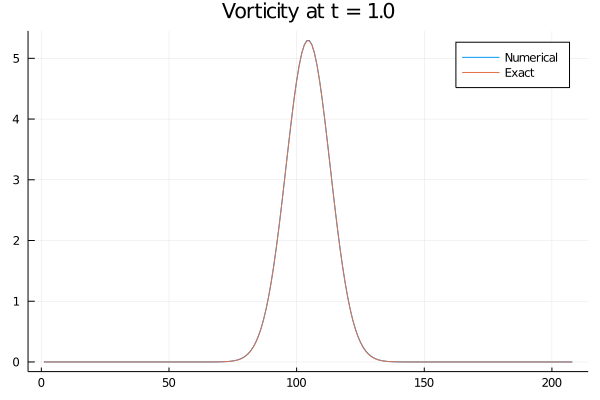

In [109]:
plot(vorticity(integrator)[:,104],label="Numerical")
plot!(vorticity(exactsol(integrator.t),sys,integrator.t)[:,104],label="Exact")
plot!(title=string("Vorticity at t = ",round(integrator.t,digits=2)))

## Second example: co-rotating vortices
The previous example is not very exciting, because the convection of the flow is simply circular. The next example is more interesting, because we will start with two vortices that influence each other's motion:

In [81]:
σ = 0.1
x01, y01 = 0.5, 0.0
x02, y02 = -0.5, 0.0
A = 1
twogauss = SpatialGaussian(σ,x01,y01,A) + SpatialGaussian(σ,x02,y02,A)

AddedFields:
  SpatialGaussian(Gaussian(0.1, 0.5, 1, 5.641895835477563), Gaussian(0.1, 0.0, 1, 5.641895835477563), 1)
  SpatialGaussian(Gaussian(0.1, -0.5, 1, 5.641895835477563), Gaussian(0.1, 0.0, 1, 5.641895835477563), 1)


### Initialize
Now, we create an instance of this vorticity distribution on the grid. 

In [82]:
u0 = newstate(twogauss,sys)

(Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), Float64[])

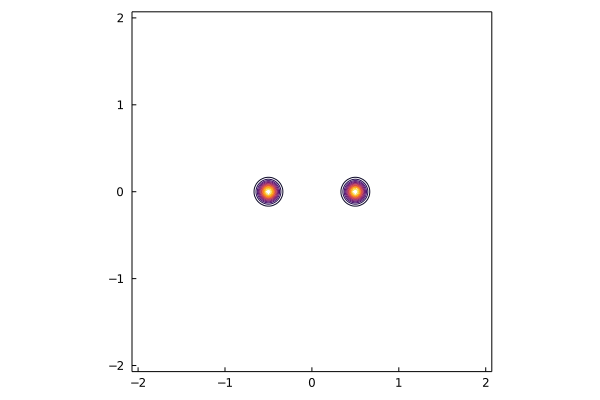

In [83]:
plot(vorticity(u0,sys,0.0),sys)

We use this initial condition to initialize the **integrator**. The integrator is the structure that holds all of our solution and operator information. With it, we can start the simulation, restart the simulation later, etc. We specify a range of time over which to advance the solution.

**Note**: This initial range is not very important, and we can always add on to it later. There is no need to restart the problem.

In [84]:
tspan = (0.0,8.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), Float64[])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 8$:

In [85]:
step!(integrator,8.0)

### Examine
In this case, it is best to view the results as an animation. In the previous example, we just looked at the final state of the integrator. Here, to animate, we will make use of the solution history that is held by the integrator, `integrator.sol`. Let's create an alias for this to shorten our commands:

In [86]:
sol = integrator.sol;

Now we will animate the solution, plotting the vorticity every 5 steps

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif")
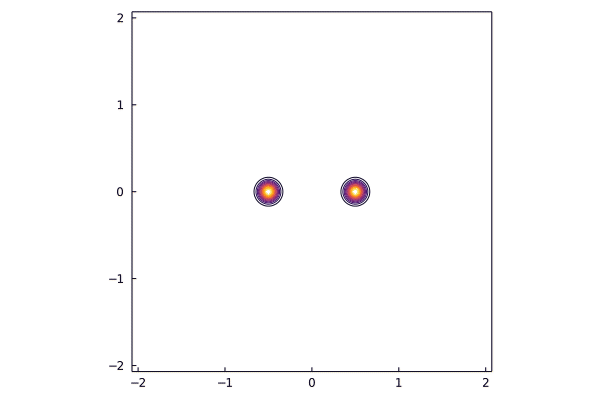

In [87]:
@gif for (u,t) in zip(sol.u,sol.t)
    plot(vorticity(u,sys,t),sys)
end every 5

The vortices orbit each other and then eventually merge together.

You are encouraged to try other examples:
* Make one or both of the vortices into elliptical shapes
* Make one stronger than the other
* Add other vortices into the initial distribution